In [147]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn import datasets
from sklearn.preprocessing import normalize
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import GaussianNB
from imblearn.over_sampling import SMOTE
#from xgboost import XGBClassifier
from sklearn.metrics import roc_curve, auc

<h1>Limpieza Credit Records</h1>


In [148]:
credit_records= pd.read_csv("C:\\Users\\gomez.gustavo\\Desktop\\Desafio_3\\credit_record.csv", sep=',', low_memory=False)
#credit_records= pd.read_csv('C:/Users/t0z006t/Documents/dh/contenidos/ds_blend_students_2020/credit_records.csv',sep=',', low_memory=False)

In [149]:
print(credit_records.head(5))
print(credit_records.shape)
print(credit_records.STATUS.value_counts())

        ID  MONTHS_BALANCE STATUS
0  5001711               0      X
1  5001711              -1      0
2  5001711              -2      0
3  5001711              -3      0
4  5001712               0      C
(1048575, 3)
C    442031
0    383120
X    209230
1     11090
5      1693
2       868
3       320
4       223
Name: STATUS, dtype: int64


In [150]:
credit_records=credit_records[credit_records.STATUS!='X']
print(credit_records.size)
print(credit_records.STATUS.value_counts())

2518035
C    442031
0    383120
1     11090
5      1693
2       868
3       320
4       223
Name: STATUS, dtype: int64


In [151]:
#cambiamos C por 0 al ser igual para el calculo de riesgo.
credit_records.STATUS.replace('C',0,inplace=True)
print(credit_records.STATUS.value_counts())
print(credit_records.info())
#Unificamos los 0
print("--------------------------------------------")
credit_records.STATUS=credit_records.STATUS.astype(int)
print(credit_records.info())
print(credit_records.STATUS.value_counts())

0    442031
0    383120
1     11090
5      1693
2       868
3       320
4       223
Name: STATUS, dtype: int64
<class 'pandas.core.frame.DataFrame'>
Int64Index: 839345 entries, 1 to 1048574
Data columns (total 3 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   ID              839345 non-null  int64 
 1   MONTHS_BALANCE  839345 non-null  int64 
 2   STATUS          839345 non-null  object
dtypes: int64(2), object(1)
memory usage: 25.6+ MB
None
--------------------------------------------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 839345 entries, 1 to 1048574
Data columns (total 3 columns):
 #   Column          Non-Null Count   Dtype
---  ------          --------------   -----
 0   ID              839345 non-null  int64
 1   MONTHS_BALANCE  839345 non-null  int64
 2   STATUS          839345 non-null  int32
dtypes: int32(1), int64(2)
memory usage: 22.4 MB
None
0    825151
1     11090
5      1693
2       868
3       320
4      

In [152]:
#Definimos la variable objetivo en funcion a aquellos que al menos presentan entre 0-30 días de atraso 1=riesdo
credit_records["riesgo"]=credit_records.STATUS.apply(lambda x: 1 if x >= 2 else 0)
print(credit_records.riesgo.value_counts())

0    836241
1      3104
Name: riesgo, dtype: int64


In [153]:
#Sumarizamos la informacion de los cleintes que al menos 1 vez hayan sido considerado de riesgos.
#dejando un solo registro de riesgo por cliente.
data_clientes=credit_records.groupby(by='ID')['riesgo'].max()
data_clientes.head(5)


ID
5001711    0
5001712    0
5001717    0
5001718    0
5001719    0
Name: riesgo, dtype: int64

<h1>Limpieza y unificación de Application Records</h1>


In [154]:
#Importamos el Dataset
#app_records= pd.read_csv('../Data/application_record.csv',sep=',', low_memory=False)
app_records= pd.read_csv("C:\\Users\\gomez.gustavo\\Desktop\\Desafio_3\\application_record.csv",sep=',', low_memory=False)


In [155]:
#Existen mas de una aplicacion por persona, dropeamos duplicados.
print(app_records.shape)
app_records=app_records.drop_duplicates(subset='ID',keep='last')
print(app_records.shape)

(438557, 18)
(438510, 18)


In [156]:
#Unificamos las planillas de applicaciones con el historial de credito 
#con el inner join solo quedan los resultados de los cuales si podemos clasificar como riesgosos

todo_junto=pd.merge(app_records,data_clientes,on='ID',how = 'inner')
print(todo_junto.shape)


(33110, 19)


In [157]:
#Generamos rangos de años de empleo con los dias empleados los resultados positivos son personas pensionadas
todo_junto['YrsEmp']=todo_junto.DAYS_EMPLOYED.apply(lambda x: 'Pensionado' if x>0 else ('<1' if ((x*-1)/365)<1 else ('1<x<3' if 1<((x*-1)/365)<3 else ('3<x<5' if 3<((x*-1)/365)<5 else '5<x+' ))))
#calculamos la edad a partir de los dias
todo_junto['edad']=todo_junto.DAYS_BIRTH.apply(lambda x : round (-x/365))
todo_junto.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33110 entries, 0 to 33109
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   33110 non-null  int64  
 1   CODE_GENDER          33110 non-null  object 
 2   FLAG_OWN_CAR         33110 non-null  object 
 3   FLAG_OWN_REALTY      33110 non-null  object 
 4   CNT_CHILDREN         33110 non-null  int64  
 5   AMT_INCOME_TOTAL     33110 non-null  float64
 6   NAME_INCOME_TYPE     33110 non-null  object 
 7   NAME_EDUCATION_TYPE  33110 non-null  object 
 8   NAME_FAMILY_STATUS   33110 non-null  object 
 9   NAME_HOUSING_TYPE    33110 non-null  object 
 10  DAYS_BIRTH           33110 non-null  int64  
 11  DAYS_EMPLOYED        33110 non-null  int64  
 12  FLAG_MOBIL           33110 non-null  int64  
 13  FLAG_WORK_PHONE      33110 non-null  int64  
 14  FLAG_PHONE           33110 non-null  int64  
 15  FLAG_EMAIL           33110 non-null 

<AxesSubplot:xlabel='ID', ylabel='CNT_FAM_MEMBERS'>

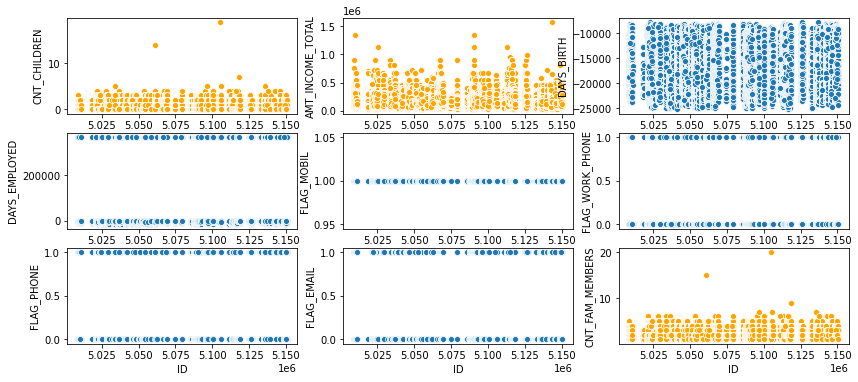

In [158]:
fig, ax= plt.subplots(nrows= 3, ncols = 3, figsize= (14,6))

sns.scatterplot(x='ID', y='CNT_CHILDREN', data=todo_junto, ax=ax[0][0], color= 'orange')
sns.scatterplot(x='ID', y='AMT_INCOME_TOTAL', data=todo_junto, ax=ax[0][1], color='orange')
sns.scatterplot(x='ID', y='DAYS_BIRTH', data=todo_junto, ax=ax[0][2])
sns.scatterplot(x='ID', y='DAYS_EMPLOYED', data=todo_junto, ax=ax[1][0])
sns.scatterplot(x='ID', y='FLAG_MOBIL', data=todo_junto, ax=ax[1][1])
sns.scatterplot(x='ID', y='FLAG_WORK_PHONE', data=todo_junto, ax=ax[1][2])
sns.scatterplot(x='ID', y='FLAG_PHONE', data=todo_junto, ax=ax[2][0])
sns.scatterplot(x='ID', y='FLAG_EMAIL', data=todo_junto, ax=ax[2][1])
sns.scatterplot(x='ID', y='CNT_FAM_MEMBERS', data=todo_junto, ax=ax[2][2], color= 'orange')

In [159]:
#Definimos limites superiores e inferiones para los outliers CNT_CHILDREN, AMT_IMCOME_TOTAL, CNT_FAM_MEMBERS
# FOR CNT_CHILDREN COLUMN
q_hi = todo_junto['CNT_CHILDREN'].quantile(0.999)
q_low = todo_junto['CNT_CHILDREN'].quantile(0.001)
todo_junto = todo_junto[(todo_junto['CNT_CHILDREN']>q_low) & (todo_junto['CNT_CHILDREN']<q_hi)]
# FOR AMT_INCOME_TOTAL COLUMN
q_hii = todo_junto['AMT_INCOME_TOTAL'].quantile(0.999)
q_loww = todo_junto['AMT_INCOME_TOTAL'].quantile(0.001)
todo_junto= todo_junto[(todo_junto['AMT_INCOME_TOTAL']>q_loww) & (todo_junto['AMT_INCOME_TOTAL']<q_hii)]
#FOR CNT_FAM_MEMBERS COLUMN
q_hiii = todo_junto['CNT_FAM_MEMBERS'].quantile(0.999)
q_lowww = todo_junto['CNT_FAM_MEMBERS'].quantile(0.001)
todo_junto= todo_junto[(todo_junto['CNT_FAM_MEMBERS']>q_lowww) & (todo_junto['CNT_FAM_MEMBERS']<q_hiii)]
todo_junto.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8527 entries, 25 to 33102
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   8527 non-null   int64  
 1   CODE_GENDER          8527 non-null   object 
 2   FLAG_OWN_CAR         8527 non-null   object 
 3   FLAG_OWN_REALTY      8527 non-null   object 
 4   CNT_CHILDREN         8527 non-null   int64  
 5   AMT_INCOME_TOTAL     8527 non-null   float64
 6   NAME_INCOME_TYPE     8527 non-null   object 
 7   NAME_EDUCATION_TYPE  8527 non-null   object 
 8   NAME_FAMILY_STATUS   8527 non-null   object 
 9   NAME_HOUSING_TYPE    8527 non-null   object 
 10  DAYS_BIRTH           8527 non-null   int64  
 11  DAYS_EMPLOYED        8527 non-null   int64  
 12  FLAG_MOBIL           8527 non-null   int64  
 13  FLAG_WORK_PHONE      8527 non-null   int64  
 14  FLAG_PHONE           8527 non-null   int64  
 15  FLAG_EMAIL           8527 non-null  

<AxesSubplot:xlabel='ID', ylabel='CNT_FAM_MEMBERS'>

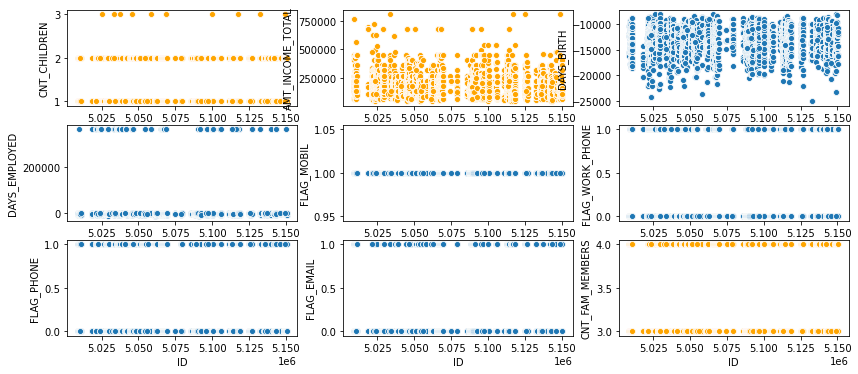

In [160]:
fig, ax= plt.subplots(nrows= 3, ncols = 3, figsize= (14,6))

sns.scatterplot(x='ID', y='CNT_CHILDREN', data=todo_junto, ax=ax[0][0], color= 'orange')
sns.scatterplot(x='ID', y='AMT_INCOME_TOTAL', data=todo_junto, ax=ax[0][1], color='orange')
sns.scatterplot(x='ID', y='DAYS_BIRTH', data=todo_junto, ax=ax[0][2])
sns.scatterplot(x='ID', y='DAYS_EMPLOYED', data=todo_junto, ax=ax[1][0])
sns.scatterplot(x='ID', y='FLAG_MOBIL', data=todo_junto, ax=ax[1][1])
sns.scatterplot(x='ID', y='FLAG_WORK_PHONE', data=todo_junto, ax=ax[1][2])
sns.scatterplot(x='ID', y='FLAG_PHONE', data=todo_junto, ax=ax[2][0])
sns.scatterplot(x='ID', y='FLAG_EMAIL', data=todo_junto, ax=ax[2][1])
sns.scatterplot(x='ID', y='CNT_FAM_MEMBERS', data=todo_junto, ax=ax[2][2], color= 'orange')

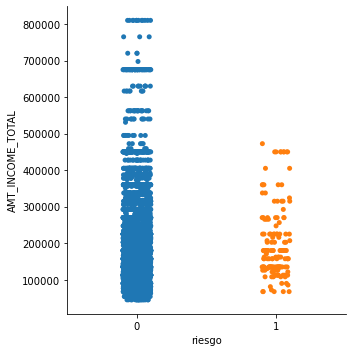

In [161]:
sns.catplot(data=todo_junto.loc[:,["AMT_INCOME_TOTAL","riesgo"]],y='AMT_INCOME_TOTAL',x='riesgo')

In [162]:
todo_junto.OCCUPATION_TYPE.value_counts()

Laborers                 1618
Core staff               1110
Sales staff              1082
Managers                  897
Drivers                   692
High skill tech staff     398
Accountants               284
Medicine staff            261
Cooking staff             147
Security staff            116
Cleaning staff            100
Private service staff      80
Secretaries                53
Low-skill Laborers         46
Realty agents              35
Waiters/barmen staff       21
HR staff                   15
IT staff                   10
Name: OCCUPATION_TYPE, dtype: int64

In [163]:
todo_junto.OCCUPATION_TYPE.isnull().sum()

1562

In [164]:
#dado que tenemos el 33% de los riesgosos sin profesion cargada desestimamos esa columna
Occupation_riesgo=todo_junto.fillna('Other')
Occupation_riesgo=Occupation_riesgo.loc[:, ["OCCUPATION_TYPE","riesgo"]]
uniques_occupations=Occupation_riesgo.OCCUPATION_TYPE.unique()
uniques_occupations
Riesgos=[]
Occupation=[]
Occupation_riesgo[Occupation_riesgo.OCCUPATION_TYPE=='Security staff'].riesgo.sum()
for i in uniques_occupations: 
    Riesgo=Occupation_riesgo[Occupation_riesgo.OCCUPATION_TYPE==i].riesgo.sum()
    Riesgos.append(Riesgo)
    Occupation.append(i)
print(Occupation)
print(Riesgos)
Occupation=pd.DataFrame(Occupation)
Occupation.columns=["Occupation"]
Riesgos=pd.DataFrame(Riesgos)
Riesgos.columns=["Riesgo"]
dataframe=pd.concat([Occupation,Riesgos],axis=1)
dataframe.sort_values(by='Riesgo',ascending=False)
Total_riesgo=dataframe.Riesgo.sum()
dataframe["%"]=dataframe.Riesgo.apply (lambda x:  x/Total_riesgo)
dataframe.sort_values(by='%',ascending=False)

['Managers', 'Laborers', 'Core staff', 'Other', 'Drivers', 'Accountants', 'Sales staff', 'High skill tech staff', 'Private service staff', 'Cooking staff', 'Secretaries', 'Cleaning staff', 'Medicine staff', 'Waiters/barmen staff', 'Low-skill Laborers', 'Security staff', 'Realty agents', 'HR staff', 'IT staff']
[20, 28, 25, 33, 10, 10, 13, 6, 0, 1, 0, 0, 0, 1, 2, 1, 0, 0, 0]


,Occupation,Riesgo,%
3,Other,33,0.220000
1,Laborers,28,0.186667
2,Core staff,25,0.166667
0,Managers,20,0.133333
6,Sales staff,13,0.086667
4,Drivers,10,0.066667
5,Accountants,10,0.066667
7,High skill tech staff,6,0.040000
14,Low-skill Laborers,2,0.013333
13,Waiters/barmen staff,1,0.006667


In [165]:
todo_junto=todo_junto.drop(['OCCUPATION_TYPE','ID','DAYS_BIRTH','DAYS_EMPLOYED','FLAG_MOBIL','FLAG_WORK_PHONE','FLAG_EMAIL'],axis=1)
print(todo_junto.shape)
todo_junto.head()
todo_junto2=pd.get_dummies(todo_junto,drop_first=True)
print(todo_junto2.shape)
todo_junto2.head()

(8527, 14)
(8527, 30)


,CNT_CHILDREN,AMT_INCOME_TOTAL,FLAG_PHONE,CNT_FAM_MEMBERS,riesgo,edad,CODE_GENDER_M,FLAG_OWN_CAR_Y,FLAG_OWN_REALTY_Y,NAME_INCOME_TYPE_Pensioner,...,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,YrsEmp_3<x<5,YrsEmp_5<x+,YrsEmp_<1,YrsEmp_Pensionado
25,1,405000.0,0,3.0,0,32,1,0,1,0,...,0,1,0,0,0,0,0,1,0,0
26,1,405000.0,0,3.0,0,32,1,0,1,0,...,0,1,0,0,0,0,0,1,0,0
27,1,405000.0,0,3.0,0,32,1,0,1,0,...,0,1,0,0,0,0,0,1,0,0
28,1,405000.0,0,3.0,0,32,1,0,1,0,...,0,1,0,0,0,0,0,1,0,0
29,1,405000.0,0,3.0,0,32,1,0,1,0,...,0,1,0,0,0,0,0,1,0,0


In [166]:
todo_junto2.to_csv('todojunto.csv')
todo_junto2.riesgo.sum()

150

<AxesSubplot:>

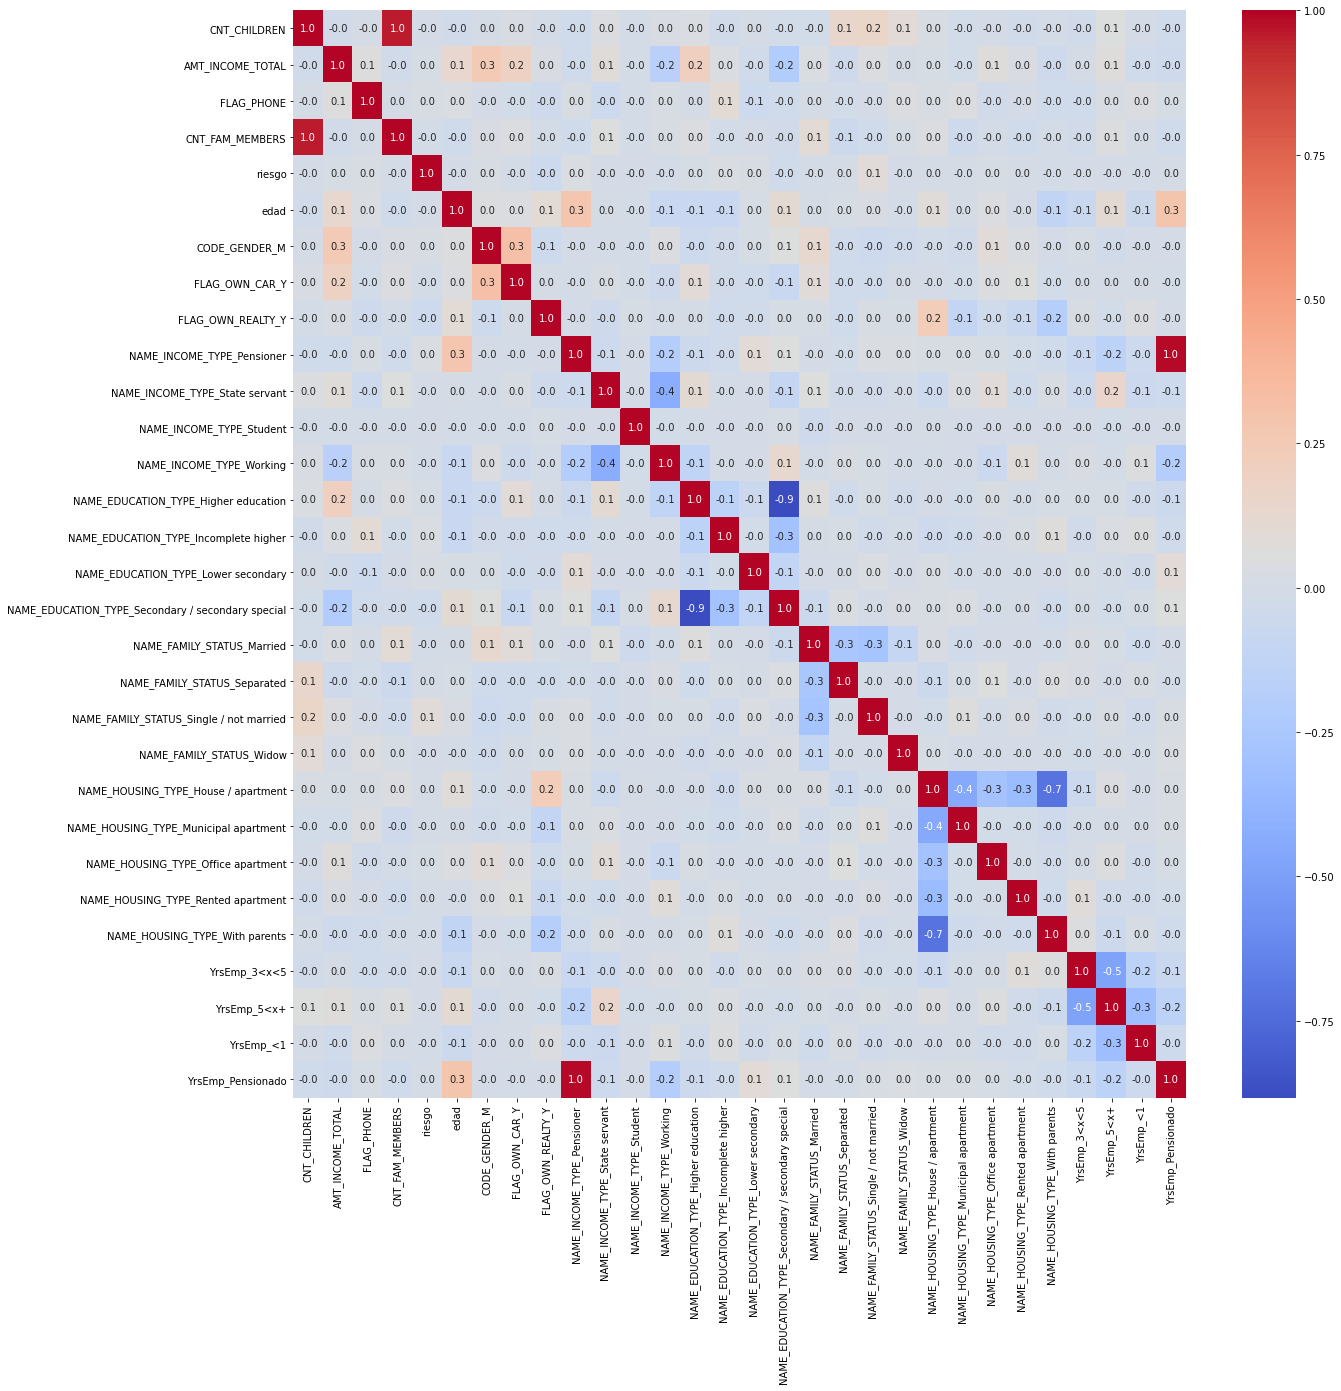

In [167]:
#sns.pairplot(todo_junto2, hue='riesgo', height=4)
plt.figure(figsize=(20,20))
sns.heatmap(todo_junto2.corr(),annot=True, fmt = ".1f", cmap = "coolwarm" )

<AxesSubplot:>

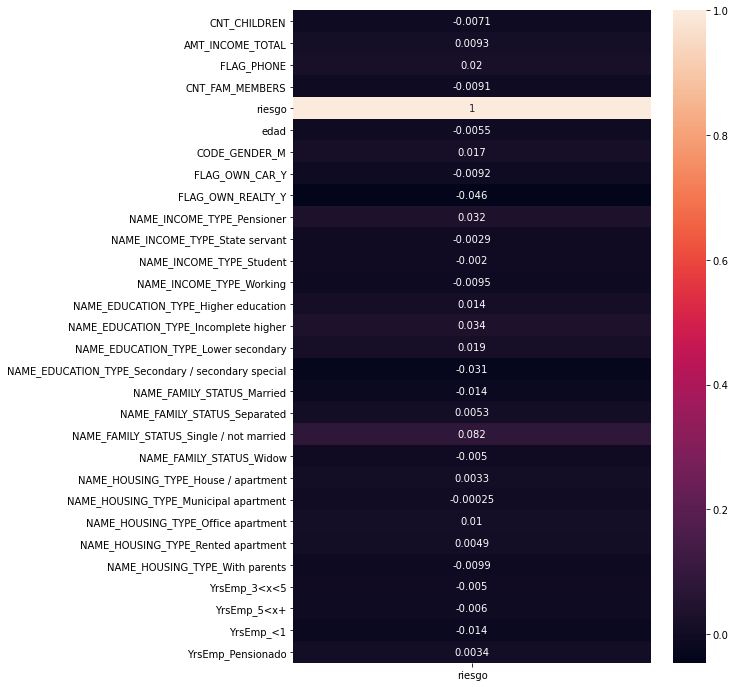

In [168]:
plt.figure(figsize=(8,12))
sns.heatmap(todo_junto2.corr()[['riesgo']], annot=True)

In [169]:
todo_junto2 = todo_junto2.drop(['CNT_CHILDREN'],axis=1)
todo_junto2 = todo_junto2.drop(['YrsEmp_Pensionado'],axis=1)
todo_junto2 = todo_junto2.drop(['NAME_EDUCATION_TYPE_Secondary / secondary special'],axis=1)
todo_junto2 = todo_junto2.drop(['NAME_HOUSING_TYPE_With parents'],axis=1)

In [170]:
todo_junto2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8527 entries, 25 to 33102
Data columns (total 26 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   AMT_INCOME_TOTAL                         8527 non-null   float64
 1   FLAG_PHONE                               8527 non-null   int64  
 2   CNT_FAM_MEMBERS                          8527 non-null   float64
 3   riesgo                                   8527 non-null   int64  
 4   edad                                     8527 non-null   int64  
 5   CODE_GENDER_M                            8527 non-null   uint8  
 6   FLAG_OWN_CAR_Y                           8527 non-null   uint8  
 7   FLAG_OWN_REALTY_Y                        8527 non-null   uint8  
 8   NAME_INCOME_TYPE_Pensioner               8527 non-null   uint8  
 9   NAME_INCOME_TYPE_State servant           8527 non-null   uint8  
 10  NAME_INCOME_TYPE_Student                 8527 

In [171]:
X = todo_junto2.drop(['riesgo'],axis=1)
y = todo_junto2['riesgo']
print(X.shape)
print(y.shape)
y.sum()

(8527, 25)
(8527,)


150

<h1>Implementar modelos</h1>

In [172]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,stratify=y)
X_train.shape
X_test.shape
y_train= y_train.astype('int')
X_train,y_train = SMOTE(k_neighbors=7,random_state=10).fit_sample(X_train,y_train)
X_train= pd.DataFrame(X_train, columns = X_train.columns)
print(X_train.shape)
print(y_train.sum())
print(y_test.sum())

(12566, 25)
6283
38


In [173]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

In [174]:
model = [LogisticRegression()]
params = [
    {'C': [1, 10, 100, 1000],
     'penalty': ['l1', 'l2',],
     'solver': ['saga']}
]

In [175]:
from sklearn.model_selection import StratifiedKFold
folds=StratifiedKFold(n_splits=10, random_state=19, shuffle=True)

In [176]:
grids = []
gs = GridSearchCV(estimator=model[0], param_grid=params, scoring='accuracy', cv=folds, n_jobs=4)
fit = gs.fit(X_train, y_train)
grids.append(fit)
grids

C:\Users\gomez.gustavo\AppData\Local\Continuum\anaconda3\envs\dhdsblend_1\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=19, shuffle=True),
              estimator=LogisticRegression(), n_jobs=4,
              param_grid=[{'C': [1, 10, 100, 1000], 'penalty': ['l1', 'l2'],
                           'solver': ['saga']}],
              scoring='accuracy')]

In [177]:
for i in grids:
    print (i.best_score_)
    print (i.best_estimator_)
    print (i.best_params_)

0.8293006298486437
LogisticRegression(C=1, solver='saga')
{'C': 1, 'penalty': 'l2', 'solver': 'saga'}


In [178]:
X_test = scaler.transform(X_test)

In [179]:
y_preds_log = grids[0].predict(X_test)

In [180]:
print (classification_report(y_test, y_preds_log))
confusion_matrix(y_test, y_preds_log)

              precision    recall  f1-score   support

           0       0.98      0.83      0.90      2094
           1       0.02      0.16      0.03        38

    accuracy                           0.82      2132
   macro avg       0.50      0.50      0.47      2132
weighted avg       0.96      0.82      0.89      2132



array([[1745,  349],
       [  32,    6]], dtype=int64)

Text(33.0, 0.5, 'Reales')

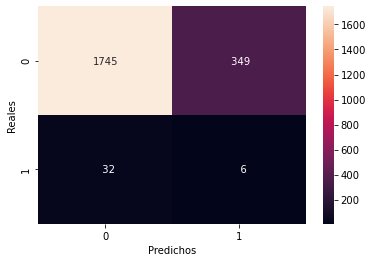

In [181]:
sns.heatmap(confusion_matrix(y_test,y_preds_log), annot=True, fmt='4d')
plt.xlabel('Predichos')
plt.ylabel('Reales')

In [182]:
umbral = 0.15
probs = grids[0].predict_proba(X_test)[:,1]
y_pred_test = probs > umbral


Text(33.0, 0.5, 'Reales')

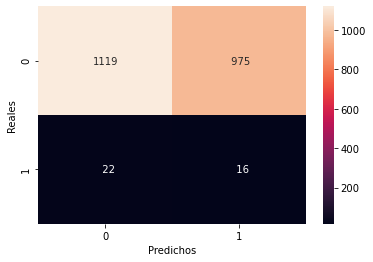

In [183]:
sns.heatmap(confusion_matrix(y_test,y_pred_test), annot=True, fmt='4d')
plt.xlabel('Predichos')
plt.ylabel('Reales')

In [184]:
model_knn=[KNeighborsClassifier()]
params = [{'n_neighbors':[2,3,4,5,6,7,8,9,10,11,12,13]}]
grids = []
gs = GridSearchCV(estimator=model_knn[0], param_grid=params, scoring='accuracy', cv=folds, n_jobs=4)
fit = gs.fit(X_train, y_train)
grids.append(fit)
grids

[GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=19, shuffle=True),
              estimator=KNeighborsClassifier(), n_jobs=4,
              param_grid=[{'n_neighbors': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                           13]}],
              scoring='accuracy')]

In [185]:
for i in grids:
    print (i.best_score_)
    print (i.best_estimator_)
    print (i.best_params_)

0.9639485758731992
KNeighborsClassifier(n_neighbors=3)
{'n_neighbors': 3}


In [186]:
y_preds_knn = grids[0].predict(X_test)
y_probs_knn = grids[0].predict_proba(X_test)
print (classification_report(y_test, y_preds_knn))


accuracy_score(y_test, y_preds_knn)

              precision    recall  f1-score   support

           0       0.99      0.98      0.98      2094
           1       0.18      0.29      0.22        38

    accuracy                           0.96      2132
   macro avg       0.59      0.63      0.60      2132
weighted avg       0.97      0.96      0.97      2132



0.9643527204502814

Text(33.0, 0.5, 'Reales')

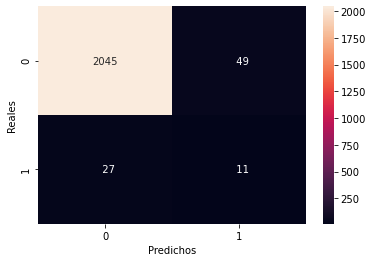

In [187]:
sns.heatmap(confusion_matrix(y_test,y_preds_knn), annot=True, fmt='4d')
plt.xlabel('Predichos')
plt.ylabel('Reales')

In [188]:
gnb = GaussianNB()

gnb.fit(X_train, y_train)

GaussianNB()

In [189]:
Y_pred = gnb.predict(X_test)
y_probs_nb = gnb.predict_proba(X_test)

Y_pred

array([0, 0, 1, ..., 1, 1, 1])

In [190]:
accuracy_score(y_test, Y_pred)

0.27345215759849906

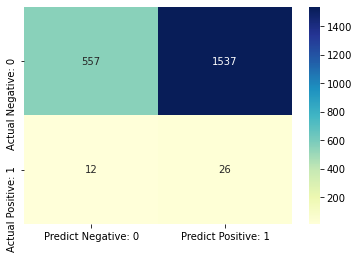

In [191]:
conf_mat = confusion_matrix(y_test, Y_pred)
conf_mat_df = pd.DataFrame(data=conf_mat, 
                           index=['Actual Negative: 0', 'Actual Positive: 1'], 
                           columns=['Predict Negative: 0', 'Predict Positive: 1'])

sns.heatmap(conf_mat_df, annot=True, fmt='d', cmap='YlGnBu');

In [192]:

model_xg=[XGBClassifier(max_depth=12,
                      n_estimators=250,
                      min_child_weight=8, 
                      subsample=0.8, 
                         
                      seed=42)]
params = [{'learning_rate':[0.01,0.02,0.03,0.1]}]
grids = []
gs = GridSearchCV(estimator=model_xg[0], param_grid=params, scoring='accuracy', cv=folds, n_jobs=4)
fit = gs.fit(X_train, y_train)
grids.append(fit)
grids
y_preds_xg = grids[0].predict(X_test)
for i in grids:
    print (i.best_score_)
    print (i.best_estimator_)
    print (i.best_params_)
print('Accuracy Score is {:.5}'.format(accuracy_score(y_test, y_preds_xg)))
print(pd.DataFrame(confusion_matrix(y_test,y_preds_xg)))
print (classification_report(y_test, y_preds_xg))

NameError: name 'XGBClassifier' is not defined

In [ ]:
y_probs_xb = grids[0].predict_proba(X_test)

fpr_nb,tpr_nb,thr_nb = roc_curve(y_test, y_probs_nb[:,1])
fpr_xb,tpr_xb,thr_xb = roc_curve(y_test, y_probs_xb[:,1])
fpr_knn,tpr_knn,thr_knn = roc_curve(y_test, y_probs_knn[:,1])


plt.axis([0, 1.01, 0, 1.01])
plt.xlabel('1 - Specificty')
plt.ylabel('TPR / Sensitivity')
plt.title('ROC Curve')
plt.plot(fpr_nb,tpr_nb)
plt.plot(fpr_xb,tpr_xb)
plt.plot(fpr_knn,tpr_knn)
plt.plot(np.arange(0,1, step =0.01), np.arange(0,1, step =0.01))
plt.legend(['NB','XB','KNN'])
plt.show()

In [ ]:
print(auc(fpr_nb,tpr_nb))
print(auc(fpr_xb,tpr_xb))
print(auc(fpr_knn,tpr_knn))

In [193]:
#clusterizamos a los solicitantes
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
scaler=StandardScaler()


1
2
3
4
5
6
7
8
9
10
11


Text(0, 0.5, 'Inertia')

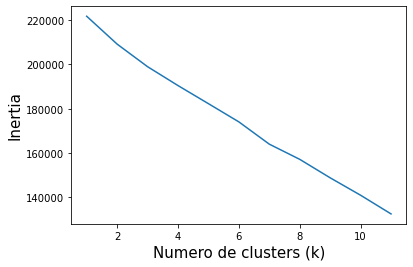

In [194]:
X=scaler.fit_transform(todo_junto2)

inertia=[]
sil=[]
ch_scores=[]
k_values=range(1,12,1)

for k in k_values:
    print(k)
    km=KMeans(n_clusters=k)
    km.fit(X)
    inertia.append(km.inertia_) 
    
plt.plot(k_values,inertia);
plt.xlabel('Numero de clusters (k)',fontsize=15);plt.ylabel('Inertia',fontsize='15')

,mean,sum,count
cluster,,,
5,0.000000,0,12
0,0.010667,8,750
1,0.015823,25,1580
4,0.017412,44,2527
6,0.018100,4,221
2,0.018524,60,3239
3,0.045455,9,198


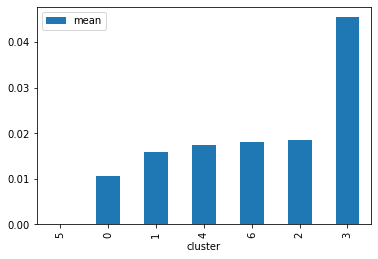

In [195]:
#probamos con distintos valores de k cuál crea los clusters más razonables, con un crecimiento considerable de un cluster a otro
#y con cantidades similares de solicitantes 3,5,7,10

k=7;
km=KMeans(n_clusters=k,random_state=0)
km.fit(X)

todo_junto2['cluster']=km.labels_
todo_junto2.groupby('cluster')['riesgo'].agg(['mean']).sort_values(by='mean',ascending=True).plot(kind='bar')
clusters=todo_junto2.groupby('cluster')['riesgo'].agg(['mean','sum','count']).sort_values(by='mean',ascending=True)
clusters

In [ ]:
#probamos con distintos valores de k cuál crea los clusters más razonables, con un crecimiento considerable de un cluster a otro
#y con cantidades similares de solicitantes 3,5,7,10

k=10;
km=KMeans(n_clusters=k,random_state=0)
km.fit(X)

todo_junto2['cluster']=km.labels_
todo_junto2.groupby('cluster')['riesgo'].agg(['mean']).sort_values(by='mean',ascending=True).plot(kind='bar')
clusters=todo_junto2.groupby('cluster')['riesgo'].agg(['mean','sum','count']).sort_values(by='mean',ascending=True)
clusters

